In [ ]:
from google.colab import drive

drive.mount('/content/drive')
!cp /path/to/dataset/on/your/drive .

Mounted at /content/drive
cp: cannot stat '/path/to/dataset/on/your/drive': No such file or directory


In [ ]:
# https://drive.google.com/file/d/1Q0quEfLdfBYv9pJ8LJtmCGTizKr2jG-Z/view?usp=sharing
!gdown --id 1Q0quEfLdfBYv9pJ8LJtmCGTizKr2jG-Z

/usr/local/lib/python3.10/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1Q0quEfLdfBYv9pJ8LJtmCGTizKr2jG-Z
To: /content/image_retrieval_dataset.zip
100% 36.5M/36.5M [00:00<00:00, 51.0MB/s]


In [ ]:
!unzip image_retrieval_dataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: images_mr/5415.jpg      
  inflating: images_mr/5416.jpg      
  inflating: images_mr/5417.jpg      
  inflating: images_mr/5418.jpg      
  inflating: images_mr/5419.jpg      
  inflating: images_mr/542.jpg       
  inflating: images_mr/5420.jpg      
  inflating: images_mr/5421.jpg      
  inflating: images_mr/5422.jpg      
  inflating: images_mr/5423.jpg      
  inflating: images_mr/5424.jpg      
  inflating: images_mr/5425.jpg      
  inflating: images_mr/5426.jpg      
  inflating: images_mr/5427.jpg      
  inflating: images_mr/5428.jpg      
  inflating: images_mr/5429.jpg      
  inflating: images_mr/543.jpg       
  inflating: images_mr/5430.jpg      
  inflating: images_mr/5431.jpg      
  inflating: images_mr/5432.jpg      
  inflating: images_mr/5433.jpg      
  inflating: images_mr/5434.jpg      
  inflating: images_mr/5435.jpg      
  inflating: images_mr/5436.jpg      
  inflating: images_mr/5437.jpg      

## 1. Import libraries

In [ ]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt

## 2. Load dataset

In [ ]:
dataset_dir = 'images_mr'
image_filenames = os.listdir(dataset_dir)
src_images = []
for filename in image_filenames:
    filepath = os.path.join(
        dataset_dir,
        filename
    )

    image = cv2.imread(filepath)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    src_images.append(image)

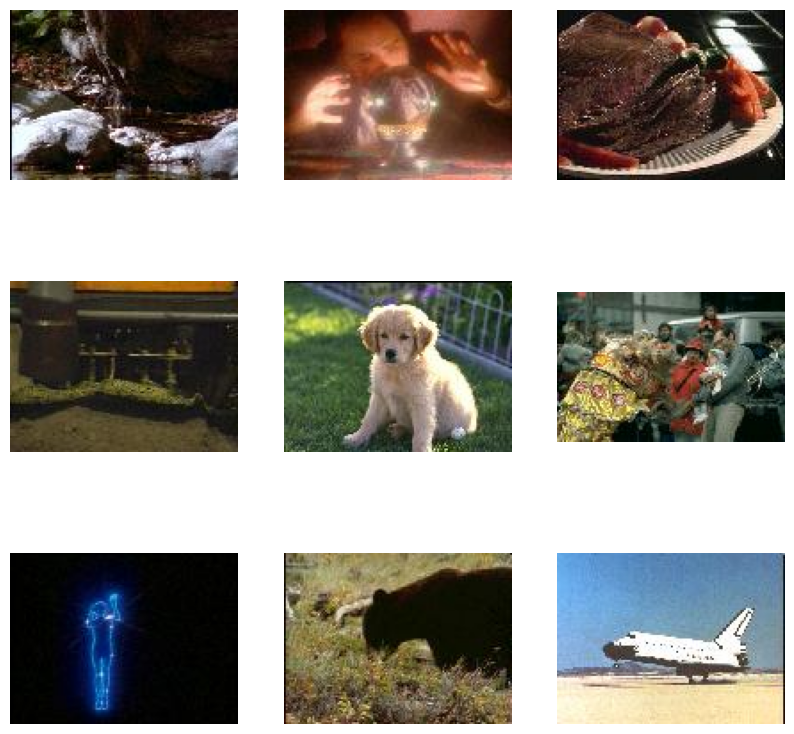

In [ ]:
# Show some images
n_rows = 3
n_cols = 3
visualize_idx = 0

fig, ax = plt.subplots(
    nrows=n_rows,
    ncols=n_cols,
    figsize=(10, 10)
)

for idx in range(n_rows):
    for jdx in range(n_cols):
        ax[idx, jdx].imshow(src_images[visualize_idx])
        ax[idx, jdx].axis('off')
        visualize_idx += 1

## 3. Preprocess images

In [ ]:
def calculate_mean_std(images):
    mean = np.mean(images, axis=(0, 1, 2))
    std = np.std(images, axis=(0, 1, 2))

    return mean, std

def image_std_normalize(images, mean, std):
    normalized_image = (images - mean) / std

    return normalized_image

def image_resize(images, target_size=(64, 64)):
    resized_image = cv2.resize(images, target_size)

    return resized_image

def image_flatten(images, is_batch=False):
    if is_batch:
        flattened_image = images.reshape(
            images.shape[0], -1
        )
    else:
        flattened_image = images.reshape(-1)

    return flattened_image

def preprocess_batches(images):
    resized_images = [
        image_resize(image) for image in src_images
    ]
    images_arr = np.array(resized_images)
    mean, std = calculate_mean_std(images_arr)
    normalized_images = image_std_normalize(
        images_arr,
        mean, std
    )
    flattened_images = image_flatten(
        normalized_images,
        is_batch=True
    )

    return flattened_images, mean, std

def preprocess_query(image):
    resized_image = image_resize(image)
    normalized_image = image_std_normalize(
        resized_image,
        mean, std
    )
    flattened_image = image_flatten(normalized_image)

    return flattened_image

In [ ]:
preprocessed_src_images, mean, std = preprocess_batches(src_images)

In [ ]:
preprocessed_src_images.shape

(9908, 12288)

## 4. Define similarity metric

In [ ]:
def mean_absolute_error(query_vector, src_vectors):
    abs_diff = np.abs(src_vectors - query_vector)
    mae = np.mean(abs_diff, axis=1)

    return mae

def mean_squared_error(query_vector, src_vectors):
    squared_diff = (src_vectors - query_vector) ** 2
    mse = np.mean(squared_diff, axis=1)

    return mse

def cosine_similarity(query_vector, src_vectors):
    query_norm = np.linalg.norm(query_vector)
    normalized_query = query_vector / query_norm
    src_norms = np.linalg.norm(src_vectors, axis=1)
    normalized_src = src_vectors / src_norms[:, np.newaxis]

    cosine_similarity = np.dot(normalized_src, normalized_query)

    return cosine_similarity

def correlation_coefficient(query_vector, src_vectors):
    return np.corrcoef(query_vector, src_vectors)[:-1, -1]

In [ ]:
test_query = preprocessed_src_images[0]

cosine_similarity(test_query, preprocessed_src_images)

array([ 1.        ,  0.109872  ,  0.06822981, ..., -0.02951523,
        0.23123609, -0.26804542])

## 5. Ranking

In [ ]:
def ranking(preprocessed_query_image, preprocessed_src_images, top_k=10):
    scores = cosine_similarity(
        preprocessed_query_image,
        preprocessed_src_images
    )
    ranked_list = np.argsort(scores)[::-1][:top_k]
    scores = scores[ranked_list]

    return ranked_list, scores

Query Image


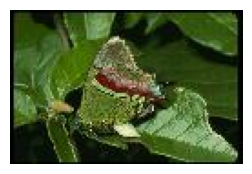

Top 10 results


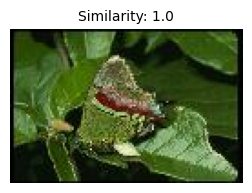

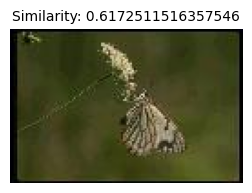

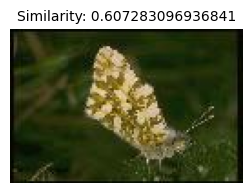

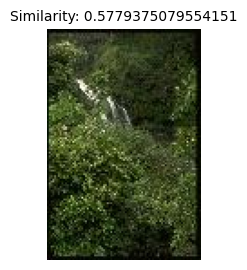

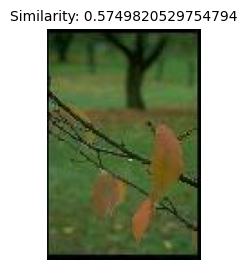

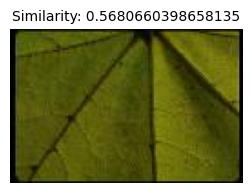

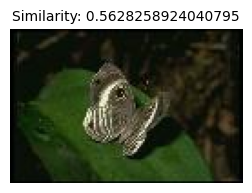

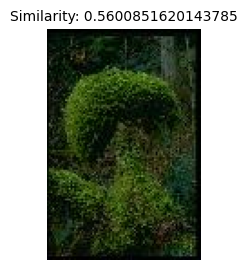

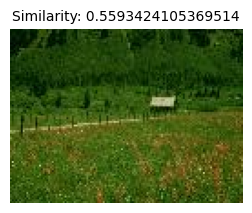

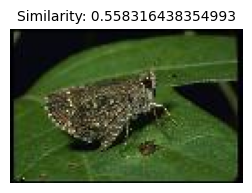

In [ ]:
query_image_paths = [
    '/content/images_mr/1.jpg'
]
top_k = 10

for query_image_path in query_image_paths:
    query_image = cv2.imread(query_image_path, 1)
    query_image = cv2.cvtColor(query_image, cv2.COLOR_BGR2RGB)
    preprocessed_query_image = preprocess_query(query_image)

    ranked_list, scores = ranking(
        preprocessed_query_image,
        preprocessed_src_images,
        top_k
    )

    print('Query Image')
    plt.figure(figsize=(3, 3))
    plt.imshow(query_image)
    plt.axis('off')
    plt.show()
    print(f'Top {top_k} results')
    for idx in range(len(ranked_list)):
        src_image_idx = ranked_list[idx]
        similarity_score = scores[idx]
        plt.figure(figsize=(3, 3))
        plt.imshow(src_images[src_image_idx])
        plt.title(f'Similarity: {similarity_score}', fontsize=10)
        plt.axis('off')
        plt.show()